#### Loading required Packages

In [218]:
from __future__  import print_function, division
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import pandas as pd 
import datetime

import geopandas as gpd
import shapely
from geopandas.tools import sjoin
from fiona.crs import from_epsg

import seaborn as sns
import imageio

import scipy as sp
from scipy import stats

from scipy.stats import ttest_ind

from sklearn.mixture import GaussianMixture 
from sklearn.decomposition import PCA

from IPython.display import HTML

### Data wrangling

In [219]:
print(os.listdir('data'))

['London-wards-2018.zip', 'journeys.csv', 'wards', 'stations.csv']


In [220]:
journeyDf = pd.read_csv('data/journeys.csv')
journeyDf.head(3)

,Journey Duration,Journey ID,End Date,End Month,End Year,End Hour,End Minute,End Station ID,Start Date,Start Month,Start Year,Start Hour,Start Minute,Start Station ID
0,2040.0,953,19,9,17,18,0,478,19,9,17,17,26,251
1,1800.0,12581,19,9,17,15,21,122,19,9,17,14,51,550
2,1140.0,1159,15,9,17,17,1,639,15,9,17,16,42,212


In [221]:
print("Rides:",journeyDf.shape[0])

Rides: 1542844


In [222]:
journeyDf.columns = [c.replace(' ','') for c in journeyDf.columns]

In [223]:
journeyDf.describe()

,JourneyDuration,JourneyID,EndDate,EndMonth,EndYear,EndHour,EndMinute,EndStationID,StartDate,StartMonth,StartYear,StartHour,StartMinute,StartStationID
count,1.542844e+06,1.542844e+06,1.542844e+06,1.542844e+06,1542844.0,1.542844e+06,1.542844e+06,1.542844e+06,1.542844e+06,1.542844e+06,1542844.0,1.542844e+06,1.542844e+06,1.542844e+06
mean,1.328576e+03,7.956525e+03,1.380986e+01,8.363004e+00,17.0,1.399076e+01,2.982176e+01,3.646432e+02,1.380797e+01,8.362890e+00,17.0,1.375762e+01,2.948512e+01,3.670164e+02
std,6.718370e+03,4.485032e+03,8.444292e+00,4.808660e-01,0.0,4.969507e+00,1.742580e+01,2.377401e+02,8.445232e+00,4.808335e-01,0.0,4.901994e+00,1.724928e+01,2.375359e+02
min,0.000000e+00,1.000000e+00,1.000000e+00,8.000000e+00,17.0,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,8.000000e+00,17.0,0.000000e+00,0.000000e+00,1.000000e+00
25%,5.100000e+02,4.104000e+03,7.000000e+00,8.000000e+00,17.0,1.000000e+01,1.500000e+01,1.620000e+02,7.000000e+00,8.000000e+00,17.0,9.000000e+00,1.400000e+01,1.640000e+02
50%,8.470000e+02,8.028000e+03,1.300000e+01,8.000000e+00,17.0,1.500000e+01,3.000000e+01,3.260000e+02,1.300000e+01,8.000000e+00,17.0,1.400000e+01,3.000000e+01,3.310000e+02
75%,1.346000e+03,1.206300e+04,1.900000e+01,9.000000e+00,17.0,1.800000e+01,4.500000e+01,5.680000e+02,1.900000e+01,9.000000e+00,17.0,1.800000e+01,4.400000e+01,5.690000e+02
max,1.984700e+06,1.511100e+04,3.100000e+01,9.000000e+00,17.0,2.300000e+01,5.900000e+01,8.260000e+02,3.100000e+01,9.000000e+00,17.0,2.300000e+01,5.900000e+01,8.260000e+02


In [224]:
journeyDf = journeyDf[journeyDf['JourneyDuration']>0]

In [225]:
journeyDf.isna().sum()

JourneyDuration    0
JourneyID          0
EndDate            0
EndMonth           0
EndYear            0
EndHour            0
EndMinute          0
EndStationID       0
StartDate          0
StartMonth         0
StartYear          0
StartHour          0
StartMinute        0
StartStationID     0
dtype: int64

In [226]:
stationsDf = pd.read_csv('data/stations.csv')
stationsDf.head(3)

,Station ID,Capacity,Latitude,Longitude,Station Name
0,1,19,51.529163,-0.109970,"River Street , Clerkenwell"
1,2,37,51.499606,-0.197574,"Phillimore Gardens, Kensington"
2,3,32,51.521283,-0.084605,"Christopher Street, Liverpool Street"


In [227]:
stationsDf.columns = [c.replace(' ','') for c in stationsDf.columns]

In [228]:
stationsDf.isna().sum()

StationID      0
Capacity       0
Latitude       0
Longitude      0
StationName    0
dtype: int64

In [229]:
journeyDf['date'] = journeyDf.apply(lambda x: datetime.datetime(year=int(2000+x.StartYear), month=int(x.StartMonth), day=int(x.StartDate)), axis=1)
journeyDf.head(3)

,JourneyDuration,JourneyID,EndDate,EndMonth,EndYear,EndHour,EndMinute,EndStationID,StartDate,StartMonth,StartYear,StartHour,StartMinute,StartStationID,date
0,2040.0,953,19,9,17,18,0,478,19,9,17,17,26,251,2017-09-19
1,1800.0,12581,19,9,17,15,21,122,19,9,17,14,51,550,2017-09-19
2,1140.0,1159,15,9,17,17,1,639,15,9,17,16,42,212,2017-09-15


### Duration EDA

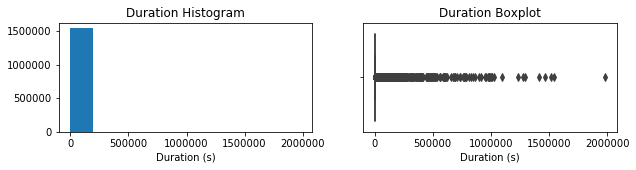

In [230]:
f, ax = plt.subplots(1, 2, figsize=(10,2))
ax[0].hist(journeyDf["JourneyDuration"])
ax[0].set_title('Duration Histogram')
ax[0].set_xlabel('Duration (s)')


_=sns.boxplot(journeyDf["JourneyDuration"], ax = ax[1])
ax[1].set_title('Duration Boxplot')
_=ax[1].set_xlabel('Duration (s)')

### There are clearly some outliers in the data.

### Outlier removal

In [231]:
std = np.std(journeyDf["JourneyDuration"])
m = np.mean(journeyDf["JourneyDuration"])
journeyDf = journeyDf[np.abs((journeyDf["JourneyDuration"]-m)/std)<3]

In [232]:
journeyDf.shape

(1538478, 15)

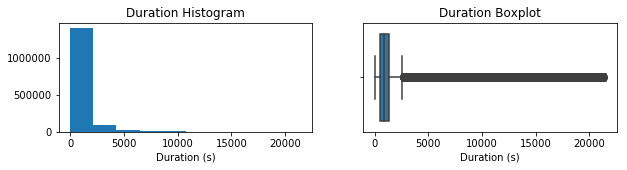

In [233]:
f, ax = plt.subplots(1, 2, figsize=(10,2))
ax[0].hist(journeyDf["JourneyDuration"])
ax[0].set_title('Duration Histogram')
ax[0].set_xlabel('Duration (s)')


_=sns.boxplot(journeyDf["JourneyDuration"], ax = ax[1])
ax[1].set_title('Duration Boxplot')
_=ax[1].set_xlabel('Duration (s)')

### The duration has right skewed distribution which closely resembles a poisson distribution.

In [234]:
journeyDf['DOW'] = journeyDf.date.apply(lambda x: x.weekday())

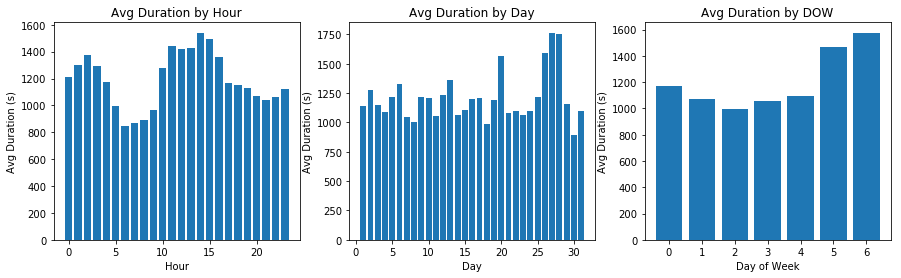

In [235]:
f, ax = plt.subplots(1, 3, figsize=(15,4))
avgDurHourDf = journeyDf[['StartHour','JourneyDuration']].groupby('StartHour').mean().reset_index()
_=ax[0].bar(avgDurHourDf.StartHour, avgDurHourDf.JourneyDuration)
ax[0].set_title('Avg Duration by Hour')
ax[0].set_xlabel('Hour')
_=ax[0].set_ylabel('Avg Duration (s)')

avgDurDateDf = journeyDf[['StartDate','JourneyDuration']].groupby('StartDate').mean().reset_index()
_=ax[1].bar(avgDurDateDf.StartDate, avgDurDateDf.JourneyDuration)
ax[1].set_title('Avg Duration by Day')
ax[1].set_xlabel('Day')
_=ax[1].set_ylabel('Avg Duration (s)')


avgDurDowDf = journeyDf[['DOW','JourneyDuration']].groupby('DOW').mean().reset_index()
_=ax[2].bar(avgDurDowDf.DOW, avgDurDowDf.JourneyDuration)
ax[2].set_title('Avg Duration by DOW')
ax[2].set_xlabel('Day of Week')
_=ax[2].set_ylabel('Avg Duration (s)')

- We can see that there is peak in avg duration during busy day hours, that could be due to traffic.
- Avg duration by day of month has a clear weekly periodic trend. 
- There is also a distinctive peak around 27,28 Aug. These could be dates of an event.
- Weekends have a higher ride duration than weekdays.

### Null Hypothesis:
The average trip duration for the weekdays is same or more than the average trip duration of weekends.
Significance level: 0.05

$ H0: μ_1 >= μ_2 $

where,

    μ1 : mean of trip duration of weekdays
    μ2 : mean of trip duration of weekends

### Alternate Hypothesis:
The average trip duration for weekdays is smaller than the average trip duration of weekends.

$ H1: μ_1 < μ_2 $

In [236]:
print('Weekends sample size:  '+str(np.sum((journeyDf.DOW==5)|(journeyDf.DOW==6))))
print('Weekdays sample size:  '+str(np.sum((journeyDf.DOW!=5)&(journeyDf.DOW!=6))))

Weekends sample size:  395060
Weekdays sample size:  1143418


In [237]:
weekends_mean = np.mean(journeyDf[(journeyDf.DOW==5)|(journeyDf.DOW==6)]['JourneyDuration'])
weekdays_mean = np.mean(journeyDf[(journeyDf.DOW!=5)&(journeyDf.DOW!=6)]['JourneyDuration'])
print("weekends mean value:",weekends_mean)
print("weekdays mean value:",weekdays_mean)

weekends_std = np.std(journeyDf[(journeyDf.DOW==5)|(journeyDf.DOW==6)]['JourneyDuration'])
weekdays_std = np.std(journeyDf[(journeyDf.DOW!=5)&(journeyDf.DOW!=6)]['JourneyDuration'])
print("weekends std value:",weekends_std)
print("weekdays std value:",weekdays_std)
ttest,pval = ttest_ind(journeyDf[(journeyDf.DOW==5)|(journeyDf.DOW==6)]['JourneyDuration'],\
                       journeyDf[(journeyDf.DOW!=5)&(journeyDf.DOW!=6)]['JourneyDuration'])
print("p-value",pval)

if pval <0.05:
    print("we reject null hypothesis")
else:
    print("we accept null hypothesis")

weekends mean value: 1521.8751987
weekdays mean value: 1078.88608016
weekends std value: 1837.38529983
weekdays std value: 1254.3859843
p-value 0.0
we reject null hypothesis


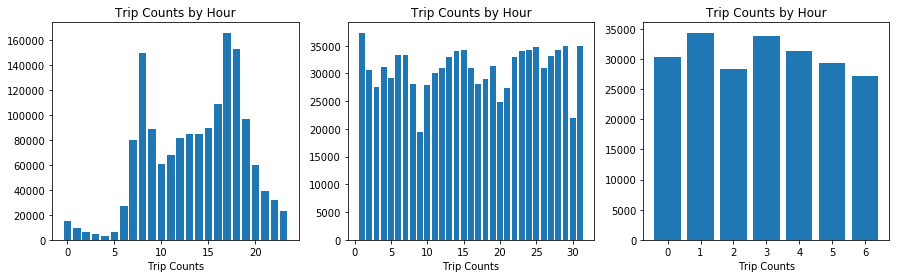

In [238]:
f, ax = plt.subplots(1, 3, figsize=(15,4))
avgDurHourDf = journeyDf[['StartHour','JourneyDuration']].groupby('StartHour').count().reset_index()
_=ax[0].bar(avgDurHourDf.StartHour, avgDurHourDf.JourneyDuration)
ax[0].set_title('Trip Counts by Hour')
_=ax[0].set_xlabel('Trip Counts')

avgDurDateDf = journeyDf[['date','JourneyDuration']].groupby('date').count().reset_index()
avgDurDateDf['day'] = avgDurDateDf.date.apply(lambda x: x.day)
avgDurDateDf = avgDurDateDf[['day','JourneyDuration']].groupby('day').mean().reset_index()
_=ax[1].bar(avgDurDateDf.day, avgDurDateDf.JourneyDuration)
ax[1].set_title('Trip Counts by Hour')
_=ax[1].set_xlabel('Trip Counts')

avgDurDateDf = journeyDf[['date','JourneyDuration']].groupby('date').count().reset_index()
avgDurDateDf['DOW'] = avgDurDateDf.date.apply(lambda x: x.weekday())
avgDurDateDf = avgDurDateDf[['DOW','JourneyDuration']].groupby('DOW').mean().reset_index()
_=ax[2].bar(avgDurDateDf.DOW, avgDurDateDf.JourneyDuration)
ax[2].set_title('Trip Counts by Hour')
_=ax[2].set_xlabel('Trip Counts')


- We can see that there is peak in ride count during to and from commute to work hours.
- Weekends have less trip counts

In [239]:
stationAggDf = journeyDf[['EndStationID','JourneyDuration']].groupby('EndStationID').count().reset_index()
stationAggDf.columns = ['StationID','countIn']
stationsDf = stationsDf.merge(stationAggDf, left_on=['StationID'], right_on=['StationID'])

stationAggDf = journeyDf[['StartStationID','JourneyDuration']].groupby('StartStationID').count().reset_index()
stationAggDf.columns = ['StationID','countOut']
stationsDf = stationsDf.merge(stationAggDf, left_on=['StationID'], right_on=['StationID'])

stationsDf.head(3)

,StationID,Capacity,Latitude,Longitude,StationName,countIn,countOut
0,1,19,51.529163,-0.109970,"River Street , Clerkenwell",874,1265
1,2,37,51.499606,-0.197574,"Phillimore Gardens, Kensington",2375,2050
2,3,32,51.521283,-0.084605,"Christopher Street, Liverpool Street",3781,3332


In [240]:
journeyDf.shape

(1538478, 16)

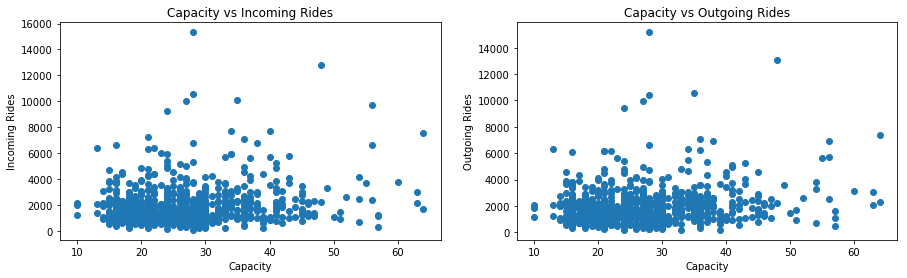

In [241]:
f, ax = plt.subplots(1, 2, figsize=(15,4))
ax[0].scatter(stationsDf.Capacity, stationsDf.countIn)
ax[0].set_title('Capacity vs Incoming Rides')
ax[0].set_ylabel('Incoming Rides')
_=ax[0].set_xlabel('Capacity')

_=ax[1].scatter(stationsDf.Capacity, stationsDf.countOut)
ax[1].set_title('Capacity vs Outgoing Rides')
ax[1].set_ylabel('Outgoing Rides')
_=ax[1].set_xlabel('Capacity')


- We can see a very slight positive correlation between capacity and ridership

In [242]:
stats.pearsonr(stationsDf.Capacity.values, stationsDf.countIn.values)

(0.15771353925145809, 1.0841470800270277e-05)

- There is slight positive correlation as confirmed by test above

### Spatial Analysis

In [243]:
shpFile = 'data/wards/ESRI/London_Ward.shp'
LondonShp = gpd.GeoDataFrame.from_file(shpFile)
print(LondonShp.shape)
LondonShp.head(3)

(657, 7)


,NAME,GSS_CODE,DISTRICT,LAGSSCODE,HECTARES,NONLD_AREA,geometry
0,Chessington South,E05000405,Kingston upon Thames,E09000021,755.173,0.0,"POLYGON ((516401.5959642464 160201.8020401799,..."
1,Tolworth and Hook Rise,E05000414,Kingston upon Thames,E09000021,259.464,0.0,"POLYGON ((519552.9984840818 164295.60020387, 5..."
2,Berrylands,E05000401,Kingston upon Thames,E09000021,145.390,0.0,"POLYGON ((518107.4991065815 167303.3992312679,..."


In [244]:
LondonShp = LondonShp.to_crs(epsg = 4326)

In [245]:
stationsDf['lonlat'] = list(zip(stationsDf["Longitude"].values,stationsDf["Latitude"].values))
stationsDf['geometry'] = stationsDf[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
stationsGDf = gpd.GeoDataFrame(stationsDf)

In [246]:
stationsGDf.crs = LondonShp.crs

In [247]:
stationsGDf = gpd.sjoin(stationsGDf,LondonShp[['NAME','geometry']],how='left').dropna()
stationsGDf.head(2)

,StationID,Capacity,Latitude,Longitude,StationName,countIn,countOut,lonlat,geometry,index_right,NAME
0,1,19,51.529163,-0.109970,"River Street , Clerkenwell",874,1265,"(-0.10997, 51.529163)",POINT (-0.10997 51.529163),539,Clerkenwell
1,2,37,51.499606,-0.197574,"Phillimore Gardens, Kensington",2375,2050,"(-0.197574, 51.499606)",POINT (-0.197574 51.499606),479,Campden


In [248]:
LondonShp = gpd.sjoin(stationsGDf[['geometry']],LondonShp[['NAME','geometry']],how='right').dropna()
LondonShp = LondonShp[['NAME','geometry']].drop_duplicates(subset=['NAME'], keep='first')

In [249]:
LondonShp = LondonShp.merge(stationsGDf[['NAME','countIn']].groupby('NAME').mean().reset_index())

In [250]:
LondonShp = LondonShp.merge(stationsGDf[['NAME','StationID']].groupby('NAME').count().reset_index())

In [251]:
LondonShp = LondonShp.merge(stationsGDf[['NAME','Capacity']].groupby('NAME').mean().reset_index())

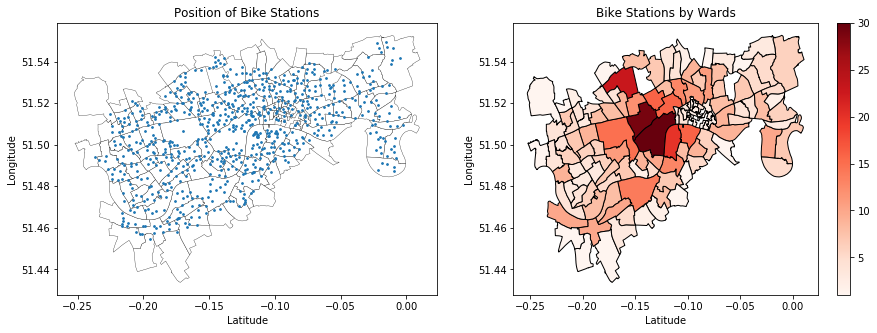

In [252]:
f, ax = plt.subplots(1, 2, figsize=(15,5))

LondonShp.plot(color='white', edgecolor='black', lw =0.3, ax=ax[0])
stationsGDf.plot(ax=ax[0], markersize=3)
ax[0].set_title('Position of Bike Stations')
ax[0].set_ylabel('Longitude')
_=ax[0].set_xlabel('Latitude')


LondonShp.plot(column="StationID", cmap="Reds",  edgecolor='black',legend=True,ax=ax[1])
ax[1].set_title('Bike Stations by Wards')
ax[1].set_ylabel('Longitude')
_=ax[1].set_xlabel('Latitude')

- There are a lot more density of bike stations in central london

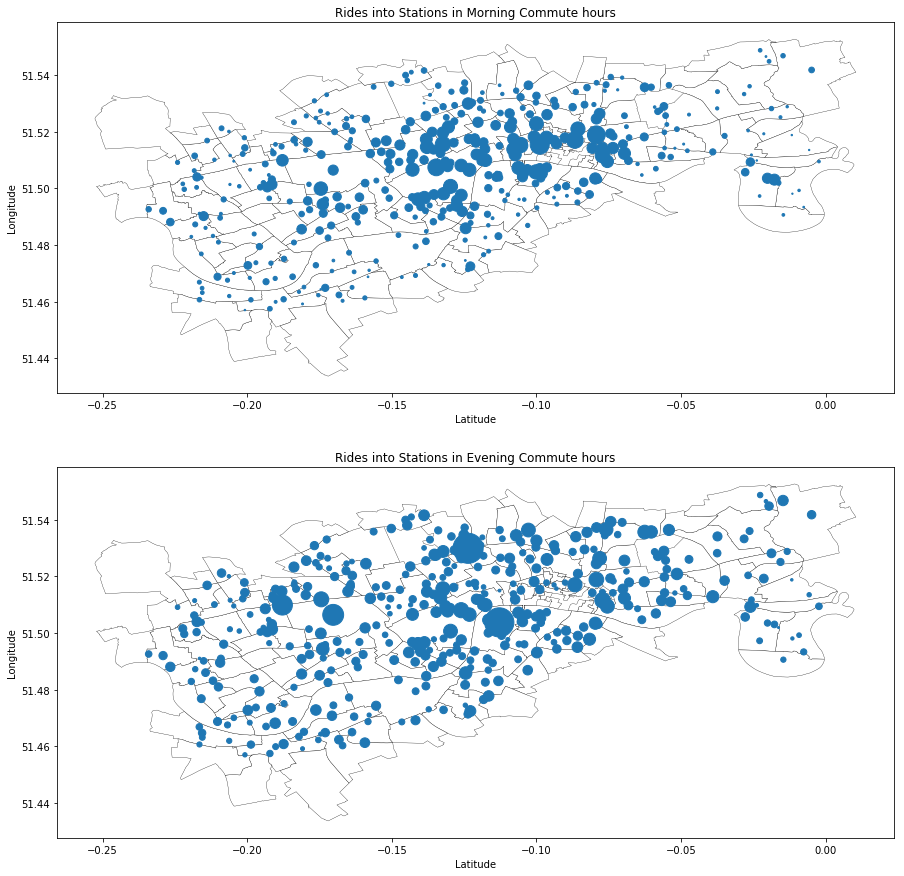

In [253]:
f, ax = plt.subplots(2, 1, figsize=(15,15))

sampleDf = stationsGDf.sample(n=400)

temp = journeyDf[(journeyDf.StartHour > 5) & (journeyDf.StartHour <= 10)][['EndStationID','JourneyDuration']]\
.groupby('EndStationID').count().reset_index()
temp.columns = ['StationID', 'TripCount']
temp = sampleDf.merge(temp, left_on=['StationID'], right_on=['StationID'], how='left')
LondonShp.plot(color='white', edgecolor='black', lw =0.3, ax=ax[0])
temp.plot(ax=ax[0], markersize=temp.TripCount/10)
ax[0].set_title('Rides into Stations in Morning Commute hours')
ax[0].set_ylabel('Longitude')
_=ax[0].set_xlabel('Latitude')

temp = journeyDf[(journeyDf.StartHour > 15) & (journeyDf.StartHour <= 20)][['EndStationID','JourneyDuration']]\
.groupby('EndStationID').count().reset_index()
temp.columns = ['StationID', 'TripCount']
temp = sampleDf.merge(temp, left_on=['StationID'], right_on=['StationID'], how='left')
LondonShp.plot(color='white', edgecolor='black', lw =0.3, ax=ax[1])
temp.plot(ax=ax[1], markersize=temp.TripCount/10)
ax[1].set_title('Rides into Stations in Evening Commute hours')
ax[1].set_ylabel('Longitude')
_=ax[1].set_xlabel('Latitude')


In [254]:
def getPlotImage(sampleDf,hour):
    fig, ax = plt.subplots(figsize=(15,7))

    temp = journeyDf[(journeyDf.StartHour == hour)][['EndStationID','JourneyDuration']]\
    .groupby('EndStationID').count().reset_index()
    temp.columns = ['StationID', 'TripCount']
    temp = sampleDf.merge(temp, left_on=['StationID'], right_on=['StationID'], how='left')
    LondonShp.plot(color='white', edgecolor='black', lw =0.3, ax=ax)
    temp.plot(ax=ax, markersize=temp.TripCount/2)
    plt.title('Hour:{}'.format(hour+1), size=16)
    
    
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    return image
    
    sampleDf = stationsGDf.sample(n=400)
    
kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('hourlyTrips4.gif', [getPlotImage(sampleDf,h) for h in range(24)], fps=1)


In [255]:
HTML('<img src="hourlyTrips4.gif">')

- The plots above show that at morning more people ride into central London and at evening people also ride towards peripherals.
- Central portions are most probably the commercial zones and outer regions are more residential regions.

In [256]:
temp1 = stationsGDf[['StationID']].copy()
temp1.columns = ['StartStation']
temp1['dummy'] = 1

temp2 = stationsGDf[['StationID']].copy()
temp2.columns = ['EndStation']
temp2['dummy'] = 1

distanceDf = temp1.merge(temp2, left_on=['dummy'], right_on=['dummy'])
distanceDf = distanceDf[['StartStation', 'EndStation']]
distanceDf.head(2)

,StartStation,EndStation
0,1,1
1,1,2


In [257]:
distanceDf = distanceDf.merge(stationsGDf, left_on=['StartStation'], right_on=['StationID'])
distanceDf = distanceDf[['StartStation', 'EndStation', 'Latitude', 'Longitude']]
distanceDf.columns = ['StartStation', 'EndStation', 'StartLat', 'StartLon']

distanceDf = distanceDf.merge(stationsGDf, left_on=['EndStation'], right_on=['StationID'])
distanceDf = distanceDf[['StartStation', 'EndStation', 'StartLat', 'StartLon', 'Latitude', 'Longitude']]
distanceDf.columns = ['StartStation', 'EndStation', 'StartLat', 'StartLon', 'EndLat', 'EndLon']

distanceDf.head(2)

,StartStation,EndStation,StartLat,StartLon,EndLat,EndLon
0,1,1,51.529163,-0.109970,51.529163,-0.10997
1,2,1,51.499606,-0.197574,51.529163,-0.10997


In [258]:
distanceDf['dist'] = distanceDf.apply(lambda x: np.power((x['StartLat'] - x['EndLat'])**2 + (x['StartLon'] - x['EndLon'])**2, 0.5), axis=1 )

In [259]:
distanceDf = distanceDf[distanceDf.StartStation != distanceDf.EndStation]
distanceDf.head(2)

,StartStation,EndStation,StartLat,StartLon,EndLat,EndLon,dist
1,2,1,51.499606,-0.197574,51.529163,-0.10997,0.092456
2,3,1,51.521283,-0.084605,51.529163,-0.10997,0.026561


In [260]:
distanceDf.dist = distanceDf.dist *100000

In [261]:
journeyDf = journeyDf.merge(distanceDf, left_on=['StartStationID','EndStationID'],\
                            right_on=['StartStation', 'EndStation'])

In [262]:
journeyDf.dist.max(),journeyDf.dist.min()

(22769.142680610537, 17.396838793186301)

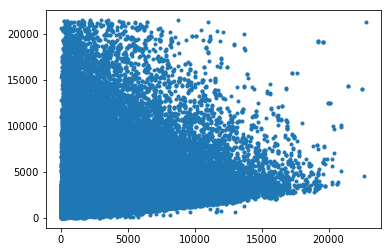

In [263]:
plt.plot(journeyDf.dist, journeyDf.JourneyDuration, '.' )

- there is no clear trend, showing that speed has high variance.

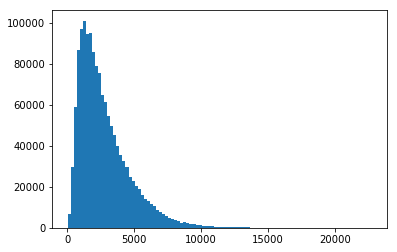

In [264]:
_=plt.hist(journeyDf.dist, bins =100)

- The rides count decrease sharply with increasing distance
- people dont ride for very small and longer distances usually

In [265]:
journeyDf['speed'] = (journeyDf['dist']) / journeyDf['JourneyDuration']

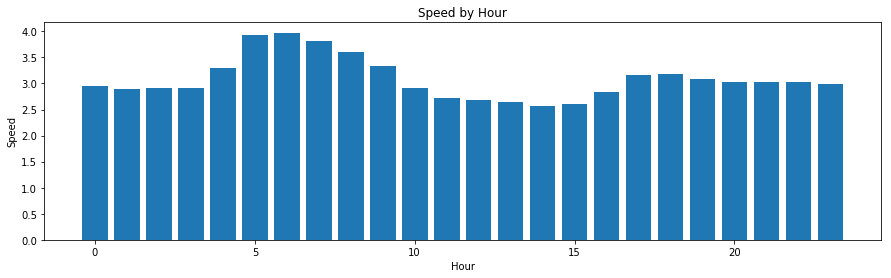

In [266]:
f, ax = plt.subplots(figsize=(15,4))
avgDurHourDf = journeyDf[['StartHour','speed']].groupby('StartHour').mean().reset_index()
_=ax.bar(avgDurHourDf.StartHour, avgDurHourDf.speed)

ax.set_title('Speed by Hour')
ax.set_ylabel('Speed')
_=ax.set_xlabel('Hour')

- It shows that the rides are fastest in the early morning hours, probably due to less traffic.

## Anomaly Detection

In [267]:
anomData= pd.pivot_table(journeyDf[['date', 'StartStation', 'EndStation', 'dist']], values='dist', index=['date'],
                    columns=['StartStation'], aggfunc=len, fill_value=0)
anomData.shape

(50, 771)

In [268]:
matrix = anomData.values
matrix.shape

(50, 771)

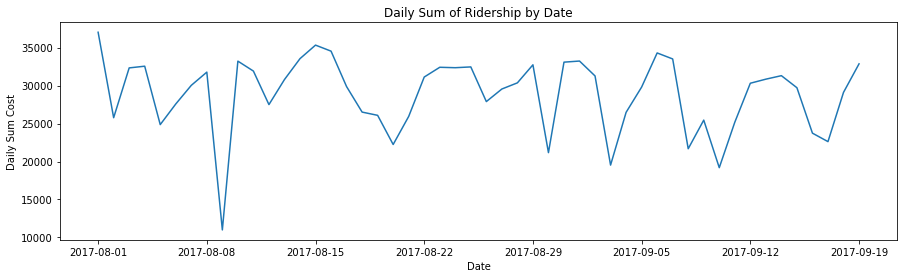

In [269]:
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(anomData.sum(axis=1))
ax.set_title('Daily Sum of Ridership by Date')
ax.set_ylabel('Daily Sum Cost')
_=ax.set_xlabel('Date')

- simple temporal plot shows that 9 aug is anomalous
- lets try something more sophisticated.

<Container object of 15 artists>

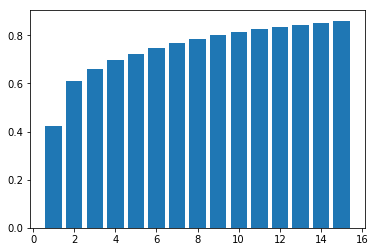

In [270]:
pca = PCA(n_components=15)
pca.fit(matrix)

plt.bar(list(range(1,16)),pca.explained_variance_ratio_.cumsum())

- 10 components can cover upto 80 % of the variance

In [271]:
pca = PCA(n_components=5)
reducedMatrixPCA = pca.fit_transform(matrix)
print(reducedMatrixPCA.shape)

(50, 5)


In [272]:
reconMatrixPCA = pca.inverse_transform(reducedMatrixPCA)
reconCostPCA = np.sum(np.power(reconMatrixPCA - matrix,2),axis = 1)
reconCostPCA = reconCostPCA.reshape(-1, 1)
reconCostPCA.shape

(50, 1)

- Reconstruction cost measures how well the linear relations are preserved in the data. So it can be used for anomaly detection.

In [273]:
def anomalyDetection(y,pval = 0.05,iterN=5,n_com=1):
    #index of regular (non-outlier points)
    #rind=y[:,0]>-10 
    rind = np.array(range(y.shape[0]))
    
    #clustering model
    gm=GaussianMixture(n_components=n_com, n_init=100, max_iter=1000,random_state=0) 
    for i in range(iterN): #iterate
        print('Iteration {}'.format(i+1))  
        clustering=gm.fit(y[rind,:]) #fit EM clustering model excluding outliers
        l=clustering.score_samples(y) #estimate likelihood for each point
        Lthres=sorted(l)[int(len(l)*pval)] #anomaly threshold
        rind0=0+rind
        rind=l>Lthres #non-anomalous points
        if all(rind==rind0):
            print('Convergence in {} iterations'.format(i+1))
            break
    return l < Lthres

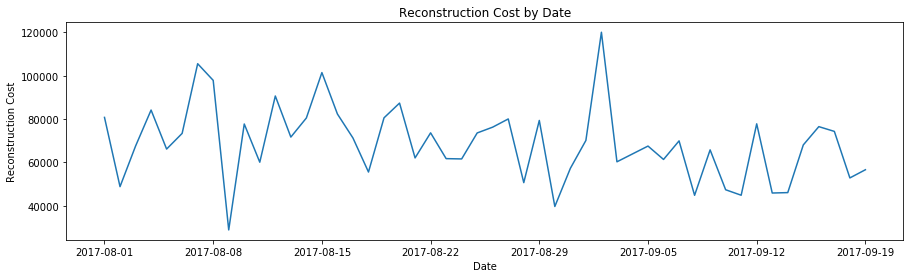

In [274]:
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(anomData.index.values,reconCostPCA)
ax.set_title('Reconstruction Cost by Date')
ax.set_ylabel('Reconstruction Cost')
_=ax.set_xlabel('Date')

In [275]:
anomIndex = anomalyDetection(reducedMatrixPCA,pval = 0.1)

Iteration 1
Iteration 2
Convergence in 2 iterations


In [276]:
np.sum(anomIndex)

5

In [277]:
anomData.index[anomIndex].values

array(['2017-08-05T00:00:00.000000000', '2017-08-06T00:00:00.000000000',
       '2017-08-13T00:00:00.000000000', '2017-08-27T00:00:00.000000000',
       '2017-08-28T00:00:00.000000000'], dtype='datetime64[ns]')

In [278]:
anomData.index[anomIndex].weekday.values

array([5, 6, 6, 6, 0])

- The two days (27,28) also had spikes on the avg duration by day plot.
- Rest of the days are all weekends
- On these days the linear trends in ridership were not preserved and longer rides occurred.